In [2]:
import re
import nltk
import random 
import spacy
import requests
import numpy as np
import pandas as pd
from pprint import pprint
from spacy import displacy
from bs4 import BeautifulSoup
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import plotly.graph_objects as go
import plotly.express as px
from utils import get_abbr_dict
from wordcloud import STOPWORDS

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

pd.set_option("display.precision", 2)
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-whitegrid')
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)

abbr_dict = get_abbr_dict()
nlp = spacy.load("en_core_web_sm")

In [3]:
df_raw = pd.read_csv('data/Cheney_2016-01-01_to_2021-12-31.csv')

/opt/anaconda3/envs/py_38_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (3,4,5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# df_raw.drop(columns='Unnamed: 0', inplace=True)

In [4]:
df_raw.head()

,author,author_flair_text,body,created_utc,score,stickied,subreddit,comment_type,is_submitter,date
0,Mr_AlGore,:yellen: Janet Yellen,Liz Cheney isnt a RINO 😡😡😡,1612212361,5,False,neoliberal,NaN,False,2021-02-01 20:46:01
1,Mandorism,NaN,"There is a mountain of proof for all of it, es...",1612211801,1,False,conspiracy,NaN,False,2021-02-01 20:36:41
2,HippieCorps,NaN,I’d agree that censoring videos of beheading a...,1612211458,-14,False,ENLIGHTENEDCENTRISM,NaN,False,2021-02-01 20:30:58
3,Strictly_Baked,NaN,There's too much connected for it to just be t...,1612210903,1,False,Cringetopia,NaN,False,2021-02-01 20:21:43
4,EmmaLouLove,NaN,"Yes, this is now the Party of Trump and it is ...",1612210769,1,False,politics,NaN,False,2021-02-01 20:19:29


In [5]:
def scrub_comments(data):
    df = data.copy(deep=True)
    df = df.loc[df.body != '', :]
    df = df[df['body'].isnull() == False]
    df['body'] = df['body'].astype("string")
    df.drop_duplicates(['body'], inplace=True)
    df['body_word_cound'] = df['body'].apply(lambda x: len(x.strip().split()))
    df['date'] = pd.to_datetime(df['date'])
    return df


def clean_comment(w):
    """This is a pretty important function"""
    # w = w.lower()
    w = w.strip()
    # remove html tags
    cleaned = re.compile('<.*?>')
    w = re.sub(cleaned, '', w)
    # remove web links
    w = re.sub(r'http\S+', '', w)
    # remove punctuation
    # w = re.sub(r'["?,\.]', '', w)
    # take out other stuff
    w = re.sub('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', '', w)
    w = " ".join(w.split())
    w = w.strip()
    return w


def clean_data(data):
    df = data.copy(deep=True)
    df['body_raw'] = df['body']
    df['body'] = df['body'].apply(lambda x: clean_comment(x))
    df['body'] = df['body'].replace(abbr_dict, regex=True, inplace=False)
    df['body_formatted'] = df['body'].str.wrap(30)
    df['body_formatted']= df['body_formatted'].apply(lambda x: x.replace('\n', '<br>'))
    return df


def show_samples(df, x1, x2, n_samples, n_chars):
    for raw, clean in zip(df.loc[0:n_samples, x1], df.loc[0:n_samples, x2]):
        print(raw[0:n_chars], "-->", clean[0:n_chars])
        

def extract_nlp(data):
    df = data.copy(deep=True)
    df['nlp'] = df['body'].apply(lambda x: nlp(x))
    df['body'] = df['nlp'].apply(
        lambda doc: " ".join([
            x.lemma_ for x in [
                y for y in nlp(str(doc)) if not y.is_stop and y.pos_ != 'PUNCT'
            ]
        ])
    )
    df['body'] = df['body'].str.lower()
    return df


def extract_persons(comment, n=3):
    person_list = []
    for ent in comment.ents:
        if ent.label_ == "PERSON":
            person_list.append(ent.text)
    person_list = [x[0] for x in Counter(person_list).most_common(n)]
    return person_list


def extract_norps(comment, n=3):
    norp_list = []
    for ent in comment.ents:
        if ent.label_ == "NORP":
            norp_list.append(ent.text)
    norp_list = [x[0] for x in Counter(norp_list).most_common(n)]
    return norp_list


def extract_orgs(comment, n=3):
    org_list = []
    for ent in comment.ents:
        if ent.label_ == "ORG":
            org_list.append(ent.text)
    org_list = [x[0] for x in Counter(org_list).most_common(n)]
    return org_list


def extract_gpes(comment, n=3):
    gpe_list = []
    for ent in comment.ents:
        if ent.label_ == "GPE":
            gpe_list.append(ent.text)
    gpe_list = [x[0] for x in Counter(gpe_list).most_common(n)]
    return gpe_list


def extract_most_common(df, n=20):
    person_list = []; norp_list = []; org_list = []; gpe_list = []
    for idx, doc in enumerate(df.iterrows()):
        for ent in doc[1]['nlp'].ents:
            if ent.label_ == "PERSON":
                person_list.append(ent.text)
            if ent.label_ == 'NORP':
                norp_list.append(ent.text)
            if ent.label_ == 'ORG':
                org_list.append(ent.text)
            if ent.label_ == 'GPE':
                gpe_list.append(ent.text)
    person_counts = Counter(person_list).most_common(n)
    norp_counts = Counter(norp_list).most_common(n)
    org_counts = Counter(org_list).most_common(n)
    gpe_counts = Counter(gpe_list).most_common(n)
    df_person = pd.DataFrame(person_counts, columns =['person', 'person_count'])
    df_norp = pd.DataFrame(norp_counts, columns =['norp', 'norp_count'])
    df_org = pd.DataFrame(org_counts, columns =['org', 'org_count'])
    df_gpe = pd.DataFrame(gpe_counts, columns =['gpe', 'gpe_count'])
    stats = pd.concat([df_person, df_norp, df_org, df_gpe], axis=1)
    return stats


def extract_entities(data):
    df = data.copy(deep=True)
    df['persons'] = df['nlp'].apply(lambda x: extract_persons(x))
    df['norps'] = df['nlp'].apply(lambda x: extract_norps(x))
    df['orgs'] = df['nlp'].apply(lambda x: extract_orgs(x))
    df['gpes'] = df['nlp'].apply(lambda x: extract_gpes(x))
    return df

In [6]:
df_scrubbed = scrub_comments(df_raw)
df = clean_data(df_scrubbed)

print("{} comments from {} unique subreddits".format(len(df), len(df.subreddit.unique())))

232709 comments from 6058 unique subreddits


In [9]:
meaningful_cols = ['body_raw', 'body', 'body_formatted', 'subreddit', 'score']

df_sample = df[meaningful_cols].groupby('subreddit', group_keys=False).apply(
    lambda x: x.sample(min(len(x), 1000))
).reset_index(drop=True)

print("{} comments from {} unique subreddits".format(len(df_sample), len(df_sample.subreddit.unique())))

116913 comments from 6057 unique subreddits


In [10]:
df_sample = extract_nlp(df_sample)

In [11]:
df_sample = extract_entities(df_sample)

In [12]:
df_sample.head(10)

,body_raw,body,subreddit,score,body_formatted,nlp,persons,norps,orgs,gpes
0,Musicals are films driven by music; which Bohe...,musical film drive music bohemian rhapsody cer...,100movies365days,2,Musicals are films driven by<br>music; which B...,"(Musicals, are, films, driven, by, music, ;, w...","[Malek, Dick Cheney]",[],[Bohemian Rhapsody],[Bale]
1,"Of the 8 films, I only watched (and finished) ...",8 film watch finish 3 bohemian rhapsody 6.6/10...,100movies365days,2.0,"Of the 8 films, I only watched<br>(and finishe...","(Of, the, 8, films, ,, I, only, watched, (, an...","[Green Book, Born, Black Panther]",[],[Bohemian Rhapsody],[Hollywood]
2,* The German air force makes its first aeropl...,german air force make aeroplane raid london ro...,100yearsago,1,* The German air force makes<br>its first aero...,"(*, The, German, air, force, makes, its, first...","[Amy Cheney Beach, Lechitski, Kirlibaba Passes]","[German, British, Russian]","[Eastern Front, LVG C.II, The French]","[London, Joffre, Rumania]"
3,**Somme River**. Canadian troops push ahead to...,somme river canadian troop push ahead north co...,100yearsago,1,**Somme River**. Canadian<br>troops push ahead...,"(*, *, Somme, River, *, *, ., Canadian, troops...","[Wilson, Lloyd George, Schwaben Redoubt]","[British, American, French]","[Gueudecourt, Allied, Lloyd George]","[Courcelette, Combles, Austria]"
4,The 1st paragraph of your previous comment was...,1st paragraph previous comment straight cultur...,100yearsago,1,The 1st paragraph of your<br>previous comment ...,"(The, 1st, paragraph, of, your, previous, comm...","[George Bush Sr., Cheney, Soros]",[democrat],"[Trump, Biden]",[]
5,All the examples you gave are the type of crim...,example give type crime redeem punish mean peo...,13ReasonsWhy,1,All the examples you gave are<br>the type of c...,"(All, the, examples, you, gave, are, the, type...",[Dick Cheney],[],[],[US]
6,What about those who perpetrate mass violence ...,perpetrate mass violence run genocidal regime ...,13ReasonsWhy,1,What about those who<br>perpetrate mass violen...,"(What, about, those, who, perpetrate, mass, vi...",[Dick Cheney],[],[],[vietnam]
7,Dick Cheney reincarnated,dick cheney reincarnate,13or30,2.0,Dick Cheney reincarnated,"(Dick, Cheney, reincarnated)",[Dick Cheney],[],[],[]
8,"Everyone saying George Costanza, but I'm gonna...",say george costanza going to dick cheney,13or30,1,"Everyone saying George<br>Costanza, but I'm go...","(Everyone, saying, George, Costanza, ,, but, I...","[George Costanza, Dick Cheney]",[],[],[]
9,He looks like Christian Bale playing Dick Cheney,look like christian bale play dick cheney,13or30,1,He looks like Christian Bale<br>playing Dick C...,"(He, looks, like, Christian, Bale, playing, Di...",[Dick Cheney],[],[Christian Bale],[]


In [13]:
df_sample.to_pickle("data/Cheney_2016-01-01_to_2021-12-31_processed.pkl")

In [14]:
df_sample.describe().transpose()

,count,unique,top,freq
body_raw,116913,116913,Musicals are films driven by music; which Bohe...,1
body,116913,113496,dick cheney,500
subreddit,116913,6057,AskReddit,1000
score,116913,741,1,56213
body_formatted,116913,116311,,99
nlp,116913,116913,"(Musicals, are, films, driven, by, music, ;, w...",1
persons,116913,38129,[Cheney],20068
norps,116913,7869,[],88817
orgs,116913,27524,[],66529
gpes,116913,13144,[],79650


In [15]:
show_samples(df_sample, "body_raw", "body", 10, 50)

Musicals are films driven by music; which Bohemian --> musical film drive music bohemian rhapsody certain
Of the 8 films, I only watched (and finished) 3 of --> 8 film watch finish 3 bohemian rhapsody 6.6/10 gre

* The German air force makes its first aeroplane  --> german air force make aeroplane raid london romani
**Somme River**. Canadian troops push ahead to the --> somme river canadian troop push ahead north cource
The 1st paragraph of your previous comment was str --> 1st paragraph previous comment straight cultural m
All the examples you gave are the type of crimes w --> example give type crime redeem punish mean people 
What about those who perpetrate mass violence or r --> perpetrate mass violence run genocidal regime star
Dick Cheney reincarnated --> dick cheney reincarnate
Everyone saying George Costanza, but I'm gonna go  --> say george costanza going to dick cheney
He looks like Christian Bale playing Dick Cheney --> look like christian bale play dick cheney
*Man* I wish o

In [16]:
stats = extract_most_common(df_sample, n=20)

In [17]:
stats

,person,person_count,norp,norp_count,org,org_count,gpe,gpe_count
0,Cheney,67256,Republicans,8085,Trump,19784,Iraq,14663
1,Dick Cheney,35956,American,7807,GOP,6219,US,13830
2,Bush,30142,Republican,7369,CIA,4488,America,5601
3,Liz Cheney,9049,Democrats,4667,Congress,2913,Obama,4546
4,Biden,5629,Americans,3463,VP,2394,Afghanistan,4150
5,Rumsfeld,5126,republicans,1762,House,2350,Iran,3327
6,Clinton,4044,Democrat,1640,Senate,2036,U.S.,3047
7,Obama,3717,Iraqi,1635,FBI,1836,Russia,2946
8,Hillary,3123,Democratic,1392,ISIS,1524,the United States,2200
9,Trump,2844,republican,1378,Taliban,1407,Israel,2080


In [18]:
def get_top_n_ngrams(corpus, n=None, grams=2):
    vec = CountVectorizer(ngram_range=(grams, grams)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [19]:
common_bigrams = get_top_n_ngrams(df_sample['body'], n=20, grams=2)
common_trigrams = get_top_n_ngrams(df_sample['body'], n=20, grams=3)
common_quadgrams = get_top_n_ngrams(df_sample['body'], n=20, grams=4)

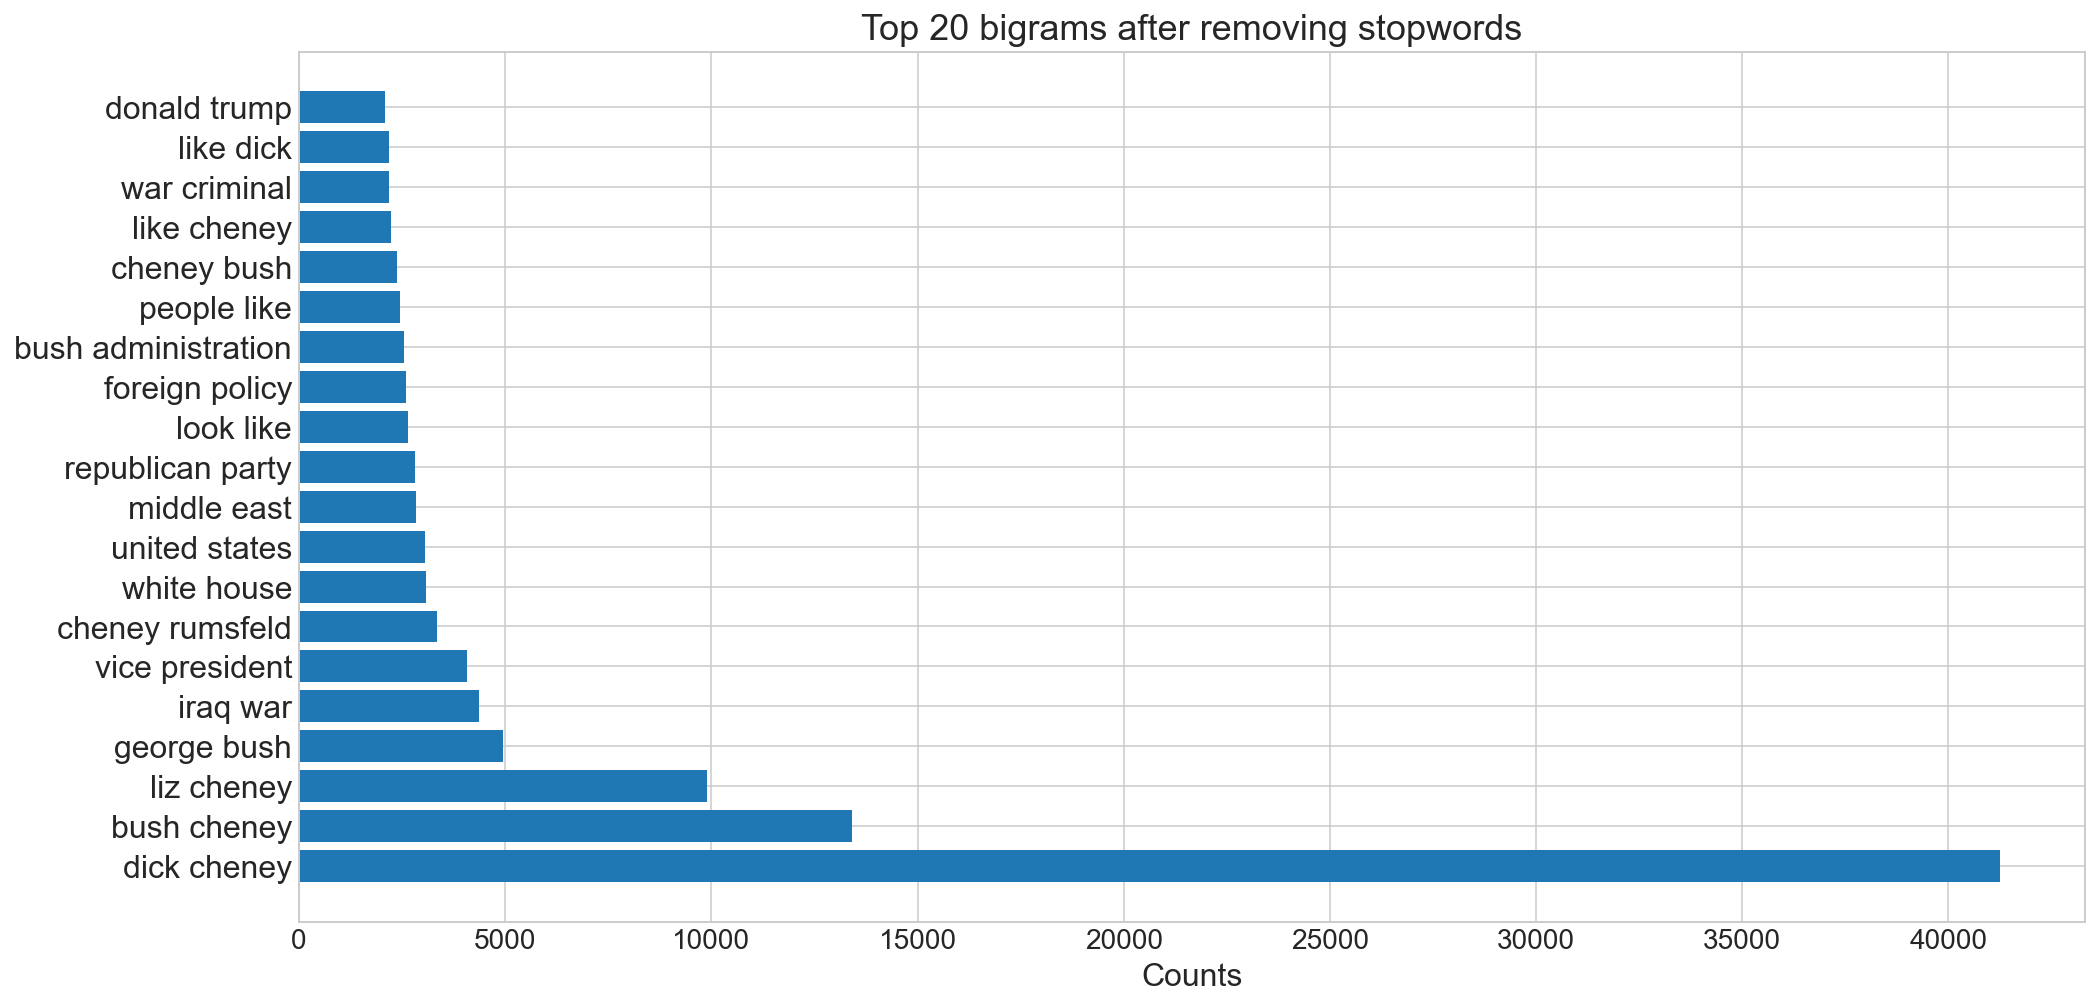

In [20]:
df2 = pd.DataFrame(common_bigrams, columns=['bigram', 'count'])
df2 = pd.DataFrame(df2.groupby('bigram').sum()['count'].sort_values(ascending=False)).reset_index()

plt.figure(figsize=(16,8))
plt.barh(df2['bigram'], df2['count'])
plt.yticks(df2['bigram'], fontsize=16)
plt.gca().set_yticklabels(df2['bigram'])
plt.xlabel('Counts', fontsize=16)
plt.title("Top 20 bigrams after removing stopwords", fontsize=18)
plt.show()

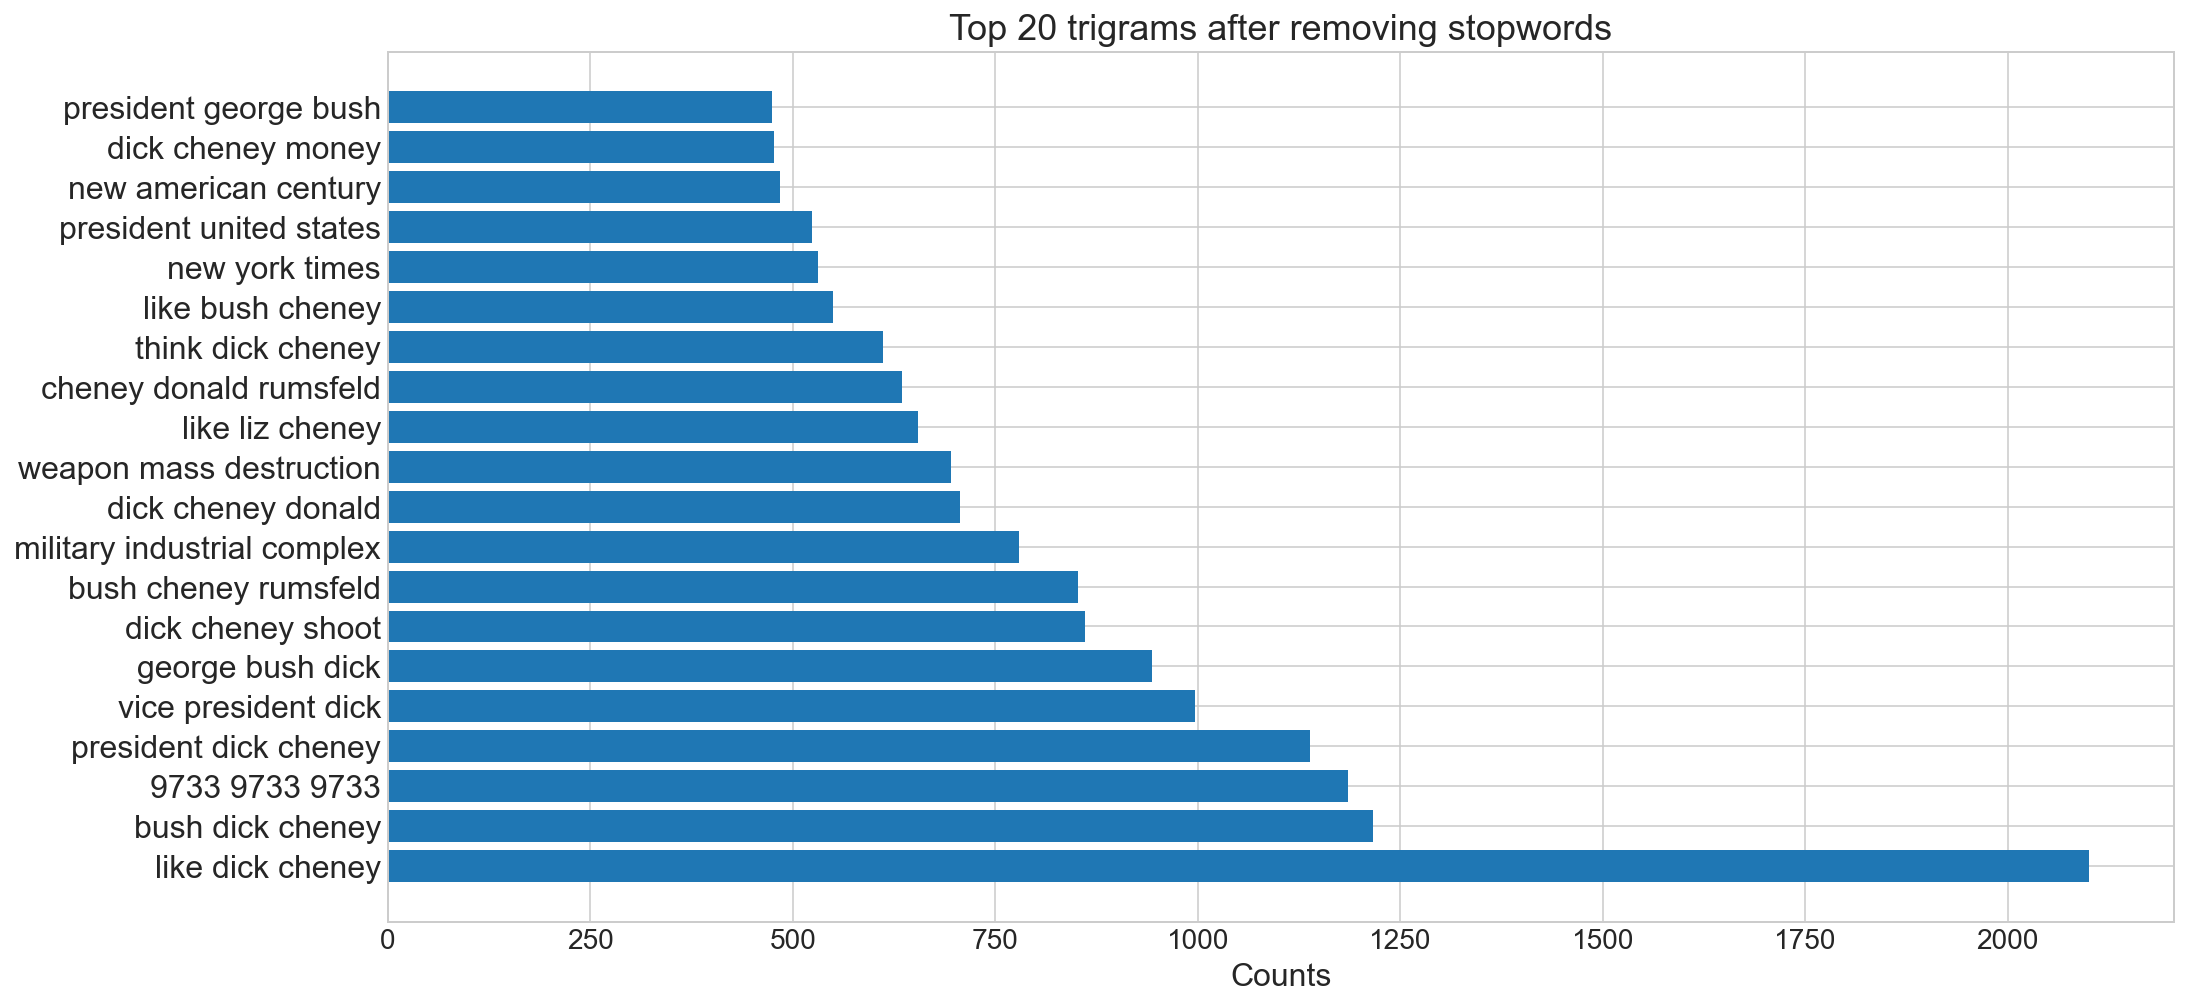

In [21]:
df3 = pd.DataFrame(common_trigrams, columns=['trigram', 'count'])
df3 = pd.DataFrame(df3.groupby('trigram').sum()['count'].sort_values(ascending=False)).reset_index()

plt.figure(figsize=(16,8))
plt.barh(df3['trigram'], df3['count'])
plt.yticks(df3['trigram'], fontsize=16)
plt.gca().set_yticklabels(df3['trigram'])
plt.xlabel('Counts', fontsize=16)
plt.title("Top 20 trigrams after removing stopwords", fontsize=18)
plt.show()

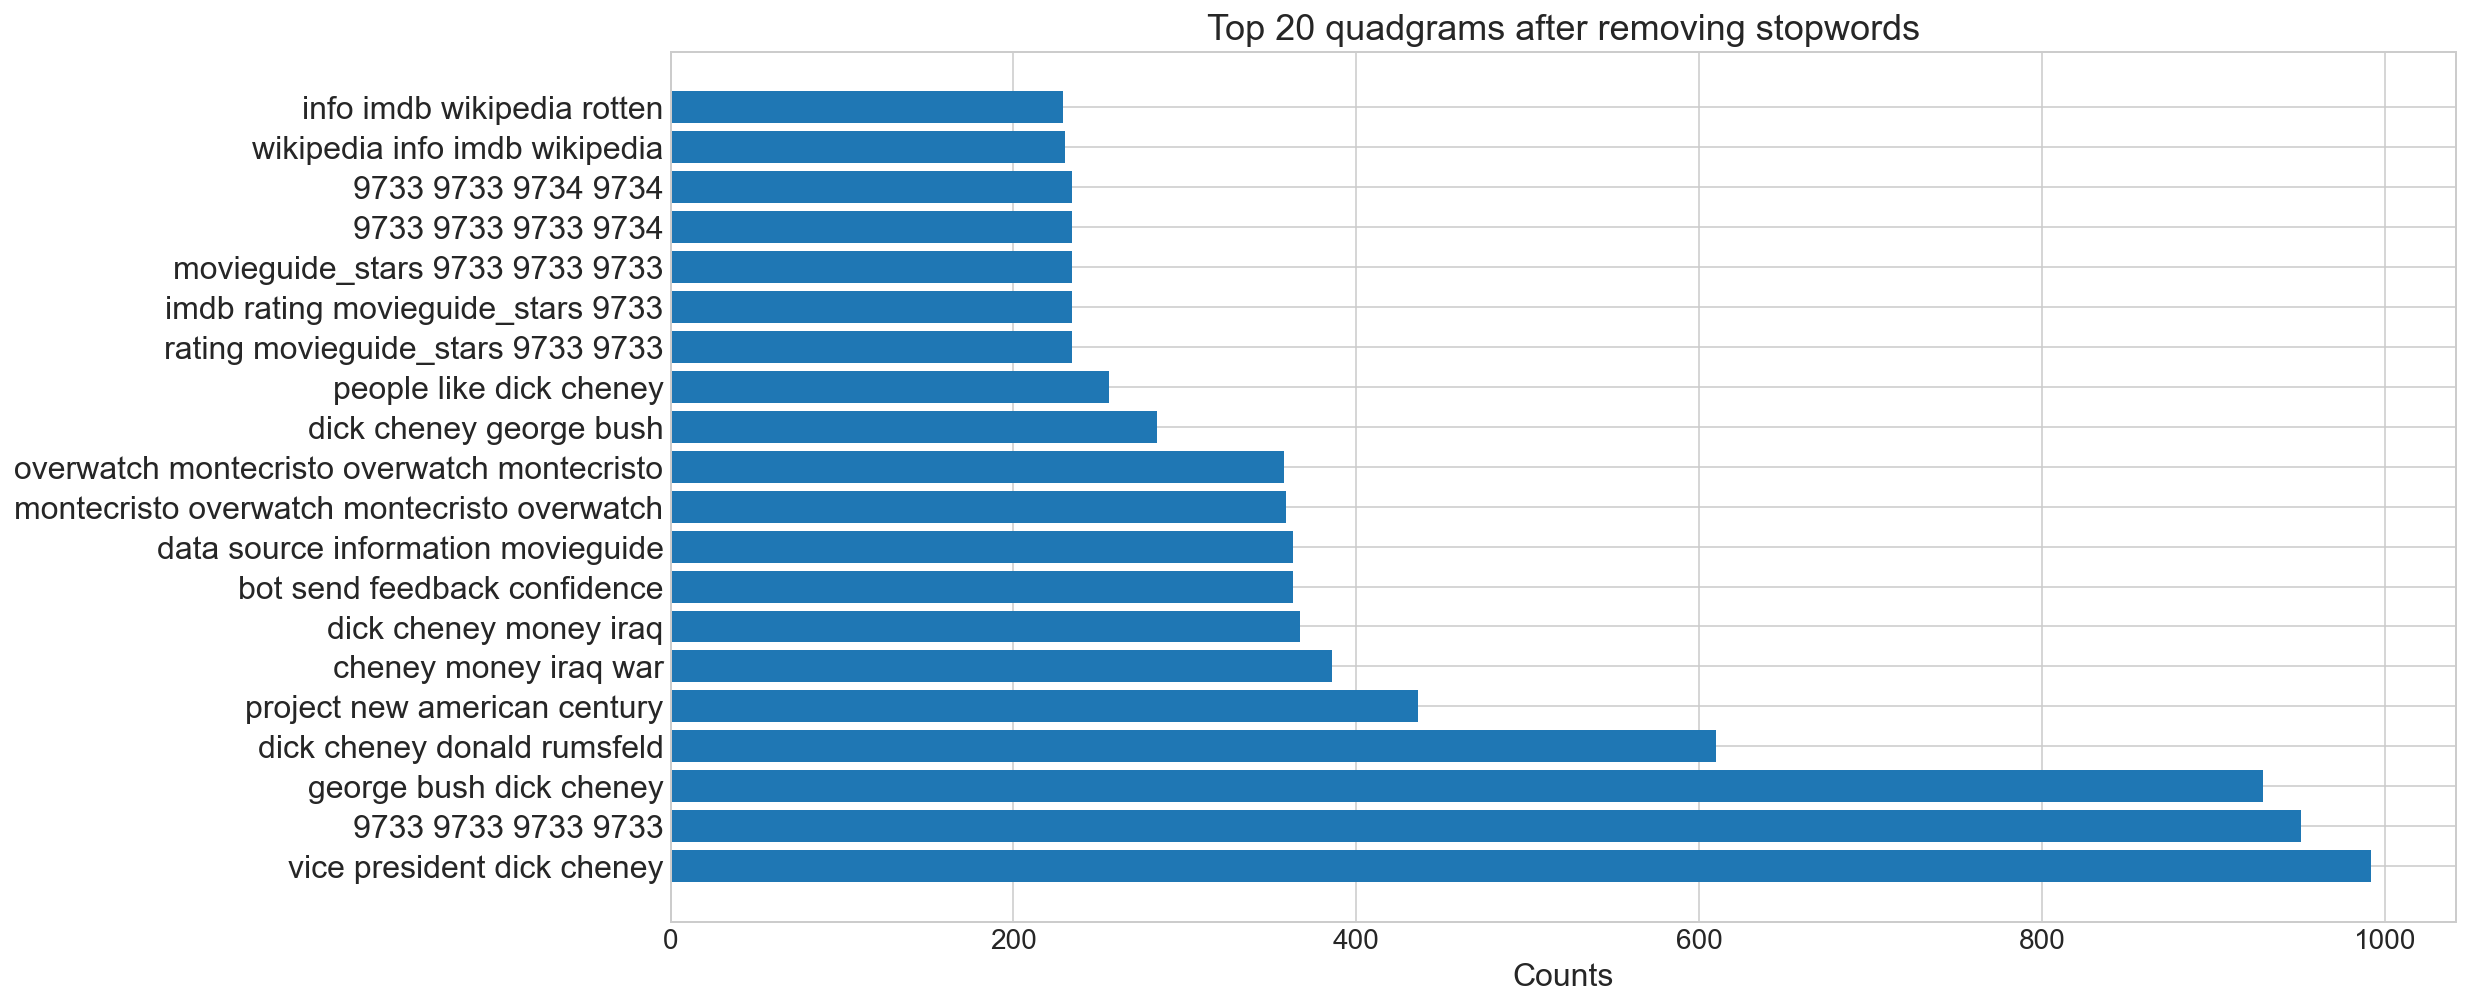

In [22]:
df4 = pd.DataFrame(common_quadgrams, columns=['quadgram', 'count'])
df4 = pd.DataFrame(df4.groupby('quadgram').sum()['count'].sort_values(ascending=False)).reset_index()

plt.figure(figsize=(16,8))
plt.barh(df4['quadgram'], df4['count'])
plt.yticks(df4['quadgram'], fontsize=16)
plt.gca().set_yticklabels(df4['quadgram'])
plt.xlabel('Counts', fontsize=16)
plt.title("Top 20 quadgrams after removing stopwords", fontsize=18)
plt.show()

In [ ]:
# df_sample[['body', 'named_entities', 'subreddit', 'score']].sample(5)

In [23]:
def format_df_for_plotting(data):
    df = data.copy(deep=True)
    df.body = df.body.str.wrap(30)
    df.body = df.body.apply(lambda x: x.replace('\n', '<br>'))
    return df


def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys


def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)


def get_top_n_words(n, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words


def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        reviews_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                reviews_in_that_topic.append(two_dim_vectors[i])    
        
        reviews_in_that_topic = np.vstack(reviews_in_that_topic)
        mean_review_in_that_topic = np.mean(reviews_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_review_in_that_topic)
    return mean_topic_vectors

In [24]:
reindexed_data = df_sample['body'].values

tfidf_vectorizer = TfidfVectorizer(max_features=2**12, use_idf=True, smooth_idf=True)

document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)

In [25]:
n_topics = 20

lsa_model = TruncatedSVD(n_components=n_topics)

lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

In [26]:
lsa_keys = get_keys(lsa_topic_matrix)

lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

top_n_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)

In [27]:
for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  dick cheney like
Topic 2:  dick pic favorite
Topic 3:  cheney liz deck
Topic 4:  bush war cheney
Topic 5:  war iraq liz
Topic 6:  trump bush republican
Topic 7:  like look cheney
Topic 8:  shoot face guy
Topic 9:  president vice cheney
Topic 10:  trump cheney vote
Topic 11:  think cheney bush
Topic 12:  fuck cheney dick
Topic 13:  know cheney dick
Topic 14:  vp biden cheney
Topic 15:  party republican vote
Topic 16:  people gay war
Topic 17:  good bale cheney
Topic 18:  hunt dick cheney
Topic 19:  rumsfeld cheney 9733
Topic 20:  bad good cheney


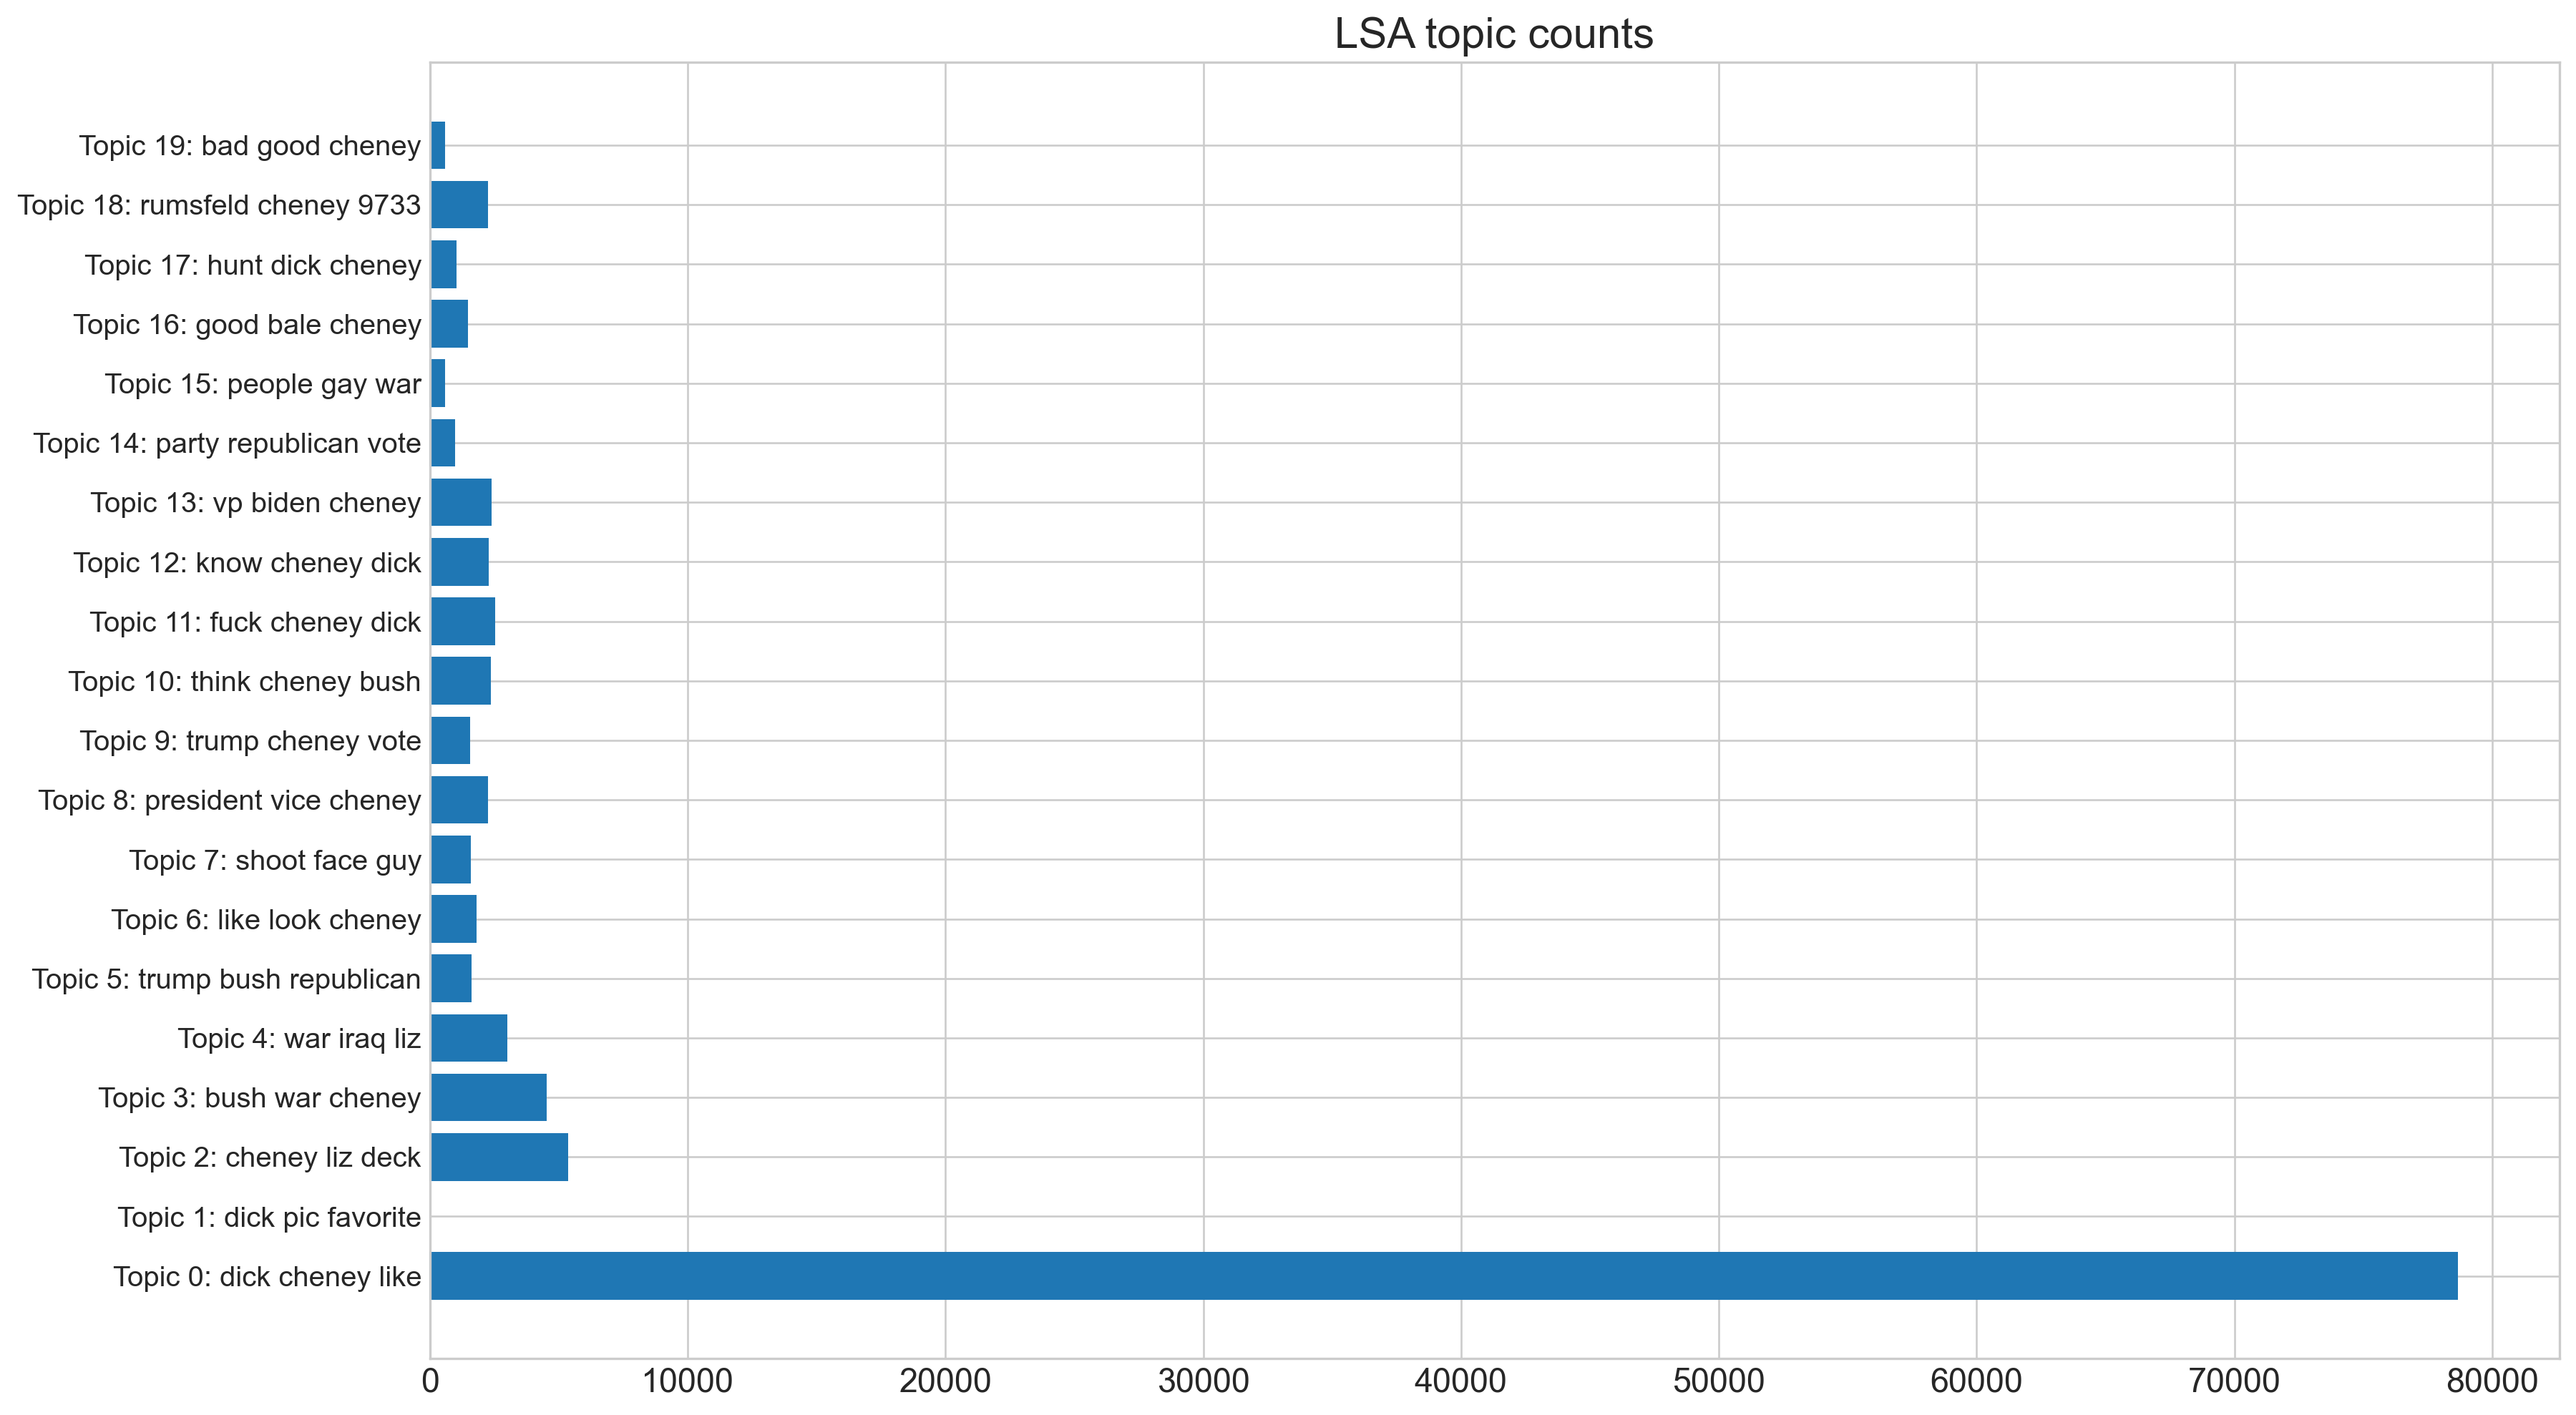

In [28]:
top_3_words = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)
labels = ['Topic {}: '.format(i) + top_3_words[i] for i in lsa_categories]

plt.figure(figsize=(16,10), dpi=120)
plt.barh(lsa_categories, lsa_counts)
plt.yticks(lsa_categories, fontsize=12)
plt.gca().set_yticklabels(labels)
plt.title('LSA topic counts', fontsize=18)
plt.show()

In [ ]:
tsne_lsa_model = TSNE(
    n_components=2, 
    perplexity=50, 
    learning_rate=100, 
    n_iter=2000, 
    verbose=1, 
    random_state=0, 
    angle=0.75
)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

/opt/anaconda3/envs/py_38_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 116913 samples in 0.001s...


In [ ]:
cmap = cm.get_cmap('twilight', n_topics)
hex_list = []
for i in range(cmap.N):
    rgba = cmap(i)
    color_hex = mpl.colors.rgb2hex(rgba)
    hex_list.append(color_hex)
colormap = np.array(hex_list)

In [ ]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

In [ ]:
fig = go.Figure(
    data = go.Scattergl(
        x = tsne_lsa_vectors[:,0],
        y = tsne_lsa_vectors[:,1],
        name = '',
        mode = 'markers',
        marker = dict(size=5, opacity=0.7, color=colormap[lsa_keys], colorscale='jet'),
        customdata = df_sample[['subreddit', 'persons', 'norps', 'orgs', 'gpes']],
        text = df_sample['body_formatted'],
        hovertemplate = '<br>'.join([
            '<b>Subreddit:</b> r/%{customdata[0]}',
            '<b>Person:</b> %{customdata[1]}',
            '<b>norp:</b> %{customdata[2]}',
            '<b>org:</b> %{customdata[3]}',
            '<b>gpe:</b> %{customdata[4]}',
            '%{text}'
        ])
    )
)

fig.update_layout(
    title = 'Journal Entries',
    template = 'ggplot2',
    height = 900,
    hoverlabel = dict(
        bgcolor = 'white', 
        font_size=14,
        font_family="Rockwell"
    )
)

fig.update_xaxes(visible=False).update_yaxes(visible=False)

for t in range(n_topics):
    fig.add_annotation(
        x=lsa_mean_topic_vectors[t][0],
        y=lsa_mean_topic_vectors[t][1],
        text=top_3_words_lsa[t],
        font=dict(size=12, color=colormap[t]),
        showarrow=False,
        opacity=0.95
    )
    
fig.show()